## 0. Set envs & Load DB, Model and Tokenizer

### Hyperparameter configuration

In [6]:
import os
import easydict

# Set path
EXP_PATH = os.path.dirname(os.getcwd())
TASK_NAME = 'px_UniKGenc'
RUN_NAME = 'KGenc_LMinit_H128_L2,2,4_px'

# Essential Hyperparameters
args = easydict.EasyDict({
    "model_type":"lxmert",
    "model_name_or_path":os.path.join(EXP_PATH,'pretrained_models',RUN_NAME),
    "tokenizer_name":"bert-base-uncased",
    "cache_dir":None,
    "eval_criterion" :"lang_acc,kg_acc",
    "block_size":-1,
    "batch_size":1,
    "eval_data_file": os.path.join(EXP_PATH,"data/{}/valid".format(TASK_NAME)),
    "test_data_file": os.path.join(EXP_PATH, "data/{}/test".format(TASK_NAME)),
    "run_name":RUN_NAME,
    "seed":1234,
})

### Environment settings

In [7]:
# Base packages
import logging
import math
from dataclasses import dataclass, field
from glob import glob
from typing import Optional
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

# Own implementation
from utils.parameters import parser
from utils.dataset import get_dataset
from utils.data_collator import NodeClassification_DataCollator
from model import LxmertForKGTokPredAndMaskedLM

# From Huggingface transformers package
from transformers import (
    CONFIG_MAPPING,
    MODEL_WITH_LM_HEAD_MAPPING,
    LxmertConfig,
    LxmertTokenizer,
    PreTrainedTokenizer,
    # Trainer,
    set_seed,
)

# Set enviroments
set_seed(args.seed)

### Load tokenizer

In [8]:
tokenizer = LxmertTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
## Sanity check
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize('Just for sanity check [CLS] [SEP] [MASK] [PAD]')))

[2074, 2005, 20039, 4638, 101, 102, 103, 0]


### Load pretrained model

In [9]:
# Load configuration
config = LxmertConfig.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)

# Load trained model
model = LxmertForKGTokPredAndMaskedLM.from_pretrained(
    args.model_name_or_path,
    from_tf=bool(".ckpt" in args.model_name_or_path),
    config=config,
    cache_dir=args.cache_dir,
)
model.eval()

## Sanity check
print('='*100)
print(config)
print('='*100)
print(model)
print('='*100)

LxmertConfig {
  "_name_or_path": "/home/ubuntu/experiments/kg_txt_multimodal/lxmert/pretrained_models/KGenc_LMinit_H128_L2,2,4_px",
  "architectures": [
    "LxmertForKGTokPredAndMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "contrastive_learning": false,
  "gcn": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "kg_special_token_ids": {
    "MASK": 1,
    "PAD": 0
  },
  "l_layers": 2,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": {
    "kg": 0,
    "lang": 512
  },
  "model_type": "lxmert",
  "negative_samples": 0,
  "num_attention_heads": 8,
  "num_attr_labels": 400,
  "num_hidden_layers": {
    "cross_encoder": 4,
    "language": 2,
    "vision": 2
  },
  "num_kg_labels": 9291,
  "num_object_labels": 1600,
  "num_qa_labels": 9500,
  "num_relations": 6,
  "pretrained_kg_embedding": "",
  "pretrained_lang_model": {
    "model_name": "prajjwal1/bert-tiny",
    "use_weight":

## 1. Class-wise accuracy

### Dataloader with masking

In [12]:
# Load model on CPU for prediction
model.cuda()

# Build vocab for grpah
id2entity = {int(line.split('\t')[1])+len(config.kg_special_token_ids):line.split('\t')[0].split('^^')[0] for line in open(os.path.join(EXP_PATH,'data',TASK_NAME, 'entity2id.txt')).read().splitlines()[1:]}
label2entity = {v:id2entity[k] for (k,v) in torch.load(os.path.join(EXP_PATH,"data/{}/id2label".format(TASK_NAME))).items()}

if args.block_size <= 0:
    args.block_size = tokenizer.max_len
    # Our input block size will be the max possible for the model
else:
    args.block_size = min(args.block_size, tokenizer.max_len)

# Get datasets
dataset = (
    get_dataset(args, tokenizer=tokenizer, kg_pad=config.kg_special_token_ids["PAD"], evaluate=True)
)

data_collator = NodeClassification_DataCollator(tokenizer=tokenizer, kg_special_token_ids=config.kg_special_token_ids, kg_size = config.vocab_size['kg'])

# Get data loader
data_loader = DataLoader(
    dataset,
    sampler=SequentialSampler(dataset),
    batch_size=args.batch_size,
    collate_fn=data_collator,
    drop_last=True,
    pin_memory=True,
)

# Sanity check
print(next(iter(data_loader))['lang_input_ids'])
print(label2entity)

/home/ubuntu/anaconda3/envs/exp/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1421: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  warnings.warn(


tensor([[  101,  1015,  1012, 20377, 22684,  5149,  2140,  2184, 11460, 10514,
          9397, 20049,  7062,  9033,  2290,  1024, 10514,  9397, 20049,  7062,
          2015, 28667,  9080,   103,  1006,  3679,  1007,  2004,  2734,  2005,
          9530,   103, 24952,  2239,  1012,  1016,  1012, 12997,  8609,   103,
          5007, 22953,   103,  1014,  1012,  6185,  1003,  5576,  9033,  2290,
          1024,  2028,  1006,  1015,  1007, 11265,  8569, 28863,  1999, 19531,
          3508,  1053,  2575,  2232,  1006,  2296,  1020,   103,   103,   103,
          2734,  2005,  1059, 21030,  6774,   103,  1017,  1012,  2632,   103,
         27833, 26754,  1016,  1012,  1019, 11460,   103,  1017, 19875,   103,
          2005, 11265,  8569, 22731,  9033,  2290,  1024,  2028,  1006,  1015,
          1007,  5576,  1999, 19531,  3508,  1053,  2575,  2232, 29733,  2296,
          1020,  2847,  1007,   103,  2734,  2005,  1059,   103,  6774,   103,
          1018,  1012, 22822, 20738, 10152,  2322,  

/home/ubuntu/experiments/kg_txt_multimodal/lxmert/src/utils/data_collator.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignore_masking = ~torch.tensor(entity_mask, dtype=torch.bool)


### Metric for class-wise accuracy

In [15]:
def get_ClassWise_Accruacy(logit, label, cwa_dict):
    _, predicted = torch.max(logit, dim=2)
    active_correct = (predicted == label)[~label.eq(-100)].tolist()
    active_label = label[~label.eq(-100)].tolist()
    for correct, label in zip(active_correct, active_label):
        cwa_dict[label].append(correct)
    return cwa_dict

### Measure class-wise accuracy

In [14]:
metrics = {'lang_cwa':{k:list() for k in range(config.vocab_size['lang'])},'kg_cwa':{k:list() for k in range(config.num_kg_labels)}}

for step, inputs in tqdm(enumerate(data_loader),total=len(data_loader)):
    # Load tensors to CUDA devices
    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.cuda()
            
    # Eval per minibatch
    with torch.no_grad():
        outputs = model(**inputs,return_dict=True)
        metrics['lang_cwa'] = get_ClassWise_Accruacy(outputs['lang_prediction_logits'].data, inputs['lm_label'].data,metrics['lang_cwa'])
        metrics['kg_cwa'] = get_ClassWise_Accruacy(outputs['kg_prediction_logits'].data, inputs['kg_label'].data,metrics['kg_cwa'])

for k in metrics:
    if 'lang' in k:
        metrics[k] = dict([(tokenizer.convert_ids_to_tokens(label),sum(correct)/len(correct)) for label, correct in list(metrics[k].items()) if len(correct)>0])
    else:
        metrics[k] = dict([(label2entity[label],sum(correct)/len(correct)) for label, correct in list(metrics[k].items()) if len(correct)>0])

100%|██████████| 2635/2635 [03:23<00:00, 12.98it/s]


### Plot class-wise accuracy distribution

Waiting for: subplots (2,1) & plot both modality in single figure

0.9977561705310396


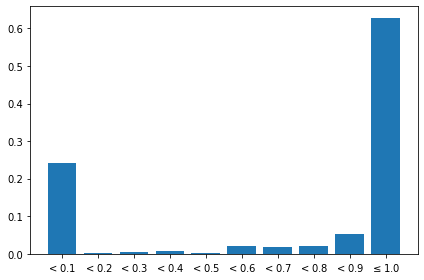

In [18]:
import matplotlib.pyplot as plt
import numpy as np

Bin = 0.1
modality = 'kg'

accs = np.array(list(metrics['{}_cwa'.format(modality)].values()))

data = list()
label = list()

for threshold in np.arange(0,1,Bin).tolist():
    if threshold+Bin < 1.0:
        data.append(np.logical_and(accs>=threshold, accs<threshold+Bin).sum()/len(accs))
        label.append('$<${:.1f}'.format(threshold+Bin))
    else:
        data.append(np.logical_and(accs>=threshold, accs<=threshold+Bin).sum()/len(accs))
        label.append('$\leq${:.1f}'.format(threshold+Bin))
print(sum(data))
plt.bar(label,data)
plt.tight_layout()
plt.show()

### Failure cases

In [17]:
P = 0.1
modality = 'lang'

failure_case = {k:v for k,v in metrics['{}_cwa'.format(modality)].items() if v<P}

print("# {} label that Acc < {} : [{}]\n".format(modality,P,len(failure_case)))
for x in [x for x in list(failure_case.keys()) if (len(x)>2) and ('#' not in x)]:
    print(x)

# lang label that Acc < 0.1 : [525]

was
from
she
had
which
first
also
who
when
into
about
just
during
between
well
later
around
did
know
get
since
high
called
place
another
area
make
following
use
face
system
let
without
within
started
received
main
son
near
history
french
center
must
million
sure
support
control
nothing
continued
does
feet
heart
keep
able
reached
hair
arms
instead
less
today
space
change
return
turn
finished
sent
ran
dead
result
available
study
talk
range
arm
getting
action
lower
changed
gone
shot
kept
future
completed
medical
bit
standing
feeling
nine
holding
additional
ask
immediately
required
starting
culture
giving
shoulder
problem
double
review
2nd
fast
administration
cell
sitting
status
separate
remaining
weight
sleep
safe
machine
electric
needs
gas
tonight
finish
visit
remain
contact
del
warm
activity
des
begin
happen
count
leg
medicine
zone
continues
worth
stomach
drug
independence
tongue
brand
nose
avoid
nor
eat
bag
billion
plus
application
transfer
details


## 2. Visualize attention score per head

### Dataloader without masking

In [11]:
# Load model on CPU for prediction
model.cpu()

if args.block_size <= 0:
    args.block_size = tokenizer.max_len
    # Our input block size will be the max possible for the model
else:
    args.block_size = min(args.block_size, tokenizer.max_len)

# Get datasets
dataset = (
    get_dataset(args, tokenizer=tokenizer, kg_pad=config.kg_special_token_ids["PAD"], evaluate=True)
)

data_collator = NodeClassification_DataCollator(tokenizer=tokenizer, kg_special_token_ids=config.kg_special_token_ids, kg_size = config.vocab_size['kg'],prediction=True)

# Get data loader
data_loader = DataLoader(
    dataset,
    sampler=SequentialSampler(dataset),
    batch_size=args.batch_size,
    collate_fn=data_collator,
    drop_last=True,
    pin_memory=True,
)

/home/ubuntu/anaconda3/envs/exp/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1421: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  warnings.warn(


### Reshaping function

In [12]:
def reshape(x,attn_type):
    if attn_type == 'txt->txt':
        output = [attn[:,:,:len(lang_tokens),:len(lang_tokens)] for attn in x]
    elif attn_type == 'kg->kg':
        output = [attn[:,:,:len(kg_tokens),:len(kg_tokens)] for attn in x]
    elif attn_type == 'txt->kg':
        output = [attn[:,:,:len(lang_tokens),:len(kg_tokens)] for attn in x]
    elif attn_type == 'kg->txt':
        output = [attn[:,:,:len(kg_tokens),:len(lang_tokens)] for attn in x]
    else:
        raise ValueError('Invalid attention type')
    return output

### Load visualization tool

In [13]:
from attentionviz import head_view

In [14]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

### Get attention score from sample

In [15]:
import matplotlib.pyplot as plt

SAMPLE_IDX = 56

id2entity = {int(line.split('\t')[1])+len(config.kg_special_token_ids):line.split('\t')[0].split('^^')[0] for line in open(os.path.join(EXP_PATH,'data','entity2id.txt')).read().splitlines()[1:]}
for idx, data in enumerate(data_loader):
    if idx==SAMPLE_IDX:
        input_data = data
        break
        
print('==== Text ====')
temp = input_data['lang_input_ids'].cpu().squeeze()
lang_tokens = tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist())
print('Token seq : {}\n'.format(lang_tokens))
print('Full sentence : {}\n\n'.format(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist()))))

print('==== KG ====')
temp = input_data['kg_input_ids'].cpu().squeeze()
kg_tokens = list(map(lambda x: id2entity[x],temp[:temp.nonzero().shape[0]].tolist()))
print('Token seq : {}\n'.format(kg_tokens))

sample = {'kg':kg_tokens,
          'txt':lang_tokens
         }


with torch.no_grad():
    output_data = model(**input_data, output_attentions=True, return_dict=True)
    attention_score = {'txt->txt':reshape(output_data['language_attentions'],'txt->txt'), 
                       'kg->kg':reshape(output_data['kg_attentions'],'kg->kg'),
                       'txt->kg':reshape(output_data['cross_encoder_attentions']['txt->kg'],'txt->kg'),
                       'kg->txt':reshape(output_data['cross_encoder_attentions']['kg->txt'],'kg->txt'),}
    print(list(output_data.keys()))
    print(attention_score['txt->kg'][0].shape)
    print(attention_score['kg->txt'][0].shape)
    print(len(attention_score['txt->txt']))
    print(len(attention_score['kg->kg']))
    print(len(attention_score['kg->txt']))
    print(len(attention_score['txt->kg']))
    head_view(attention_score, sample)

==== Text ====
Token seq : ['[CLS]', 'int', '##uba', '##tion', 'ne', '##uro', '-', 'intervention', '/', 'cl', '##ot', 'retrieval', '[SEP]']

Full sentence : [CLS] intubation neuro - intervention / clot retrieval [SEP]


==== KG ====
Token seq : ['</hadm_id/164563>', '</procedures/7198>', '</procedures/7197>', '</procedures/7188>', '</procedures/7193>', '</procedures/7190>', '</procedures/7196>', '</procedures/7195>', '</procedures/7192>', '</procedures/7191>', '</procedures/7189>', '</procedures/7194>', '</procedures_icd9_code/14>', '</procedures_icd9_code/966>', '</procedures_icd9_code/4513>', '</procedures_icd9_code/3891>', '</procedures_icd9_code/9671>', '</procedures_icd9_code/17>', '</procedures_icd9_code/3323>', '</procedures_icd9_code/9672>', '</procedures_icd9_code/9604>', '</procedures_icd9_code/3893>', '</procedures_icd9_code/311>', '"injection oxazolidinone"', '"injection or infusion of oxazolidinone class of antibiotics"', '"enteral infusion of concentrated nutritional subs

<ipython-input-15-0de9ea9775a7>:13: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  lang_tokens = tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist())


AttributeError: 'NoneType' object has no attribute 'unsqueeze'

In [16]:
print(input_data)

{'lang_input_ids': tensor([[  101, 20014, 19761,  3508, 11265, 10976,  1011,  8830,  1013, 18856,
          4140, 26384,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,    

## <span style="color:skyblue">Supp 1. Visualize attention score in matrix form</span>

### Dataloader without masking

In [ ]:
# Load model on CPU for prediction
model.cpu()

if args.block_size <= 0:
    args.block_size = tokenizer.max_len
    # Our input block size will be the max possible for the model
else:
    args.block_size = min(args.block_size, tokenizer.max_len)

# Get datasets
dataset = (
    get_dataset(args, tokenizer=tokenizer, kg_pad=config.kg_special_token_ids["PAD"], evaluate=True)
)

data_collator = NodeClassification_DataCollator(tokenizer=tokenizer, kg_special_token_ids=config.kg_special_token_ids, kg_size = config.vocab_size['kg'],prediction=True)

# Get data loader
data_loader = DataLoader(
    dataset,
    sampler=SequentialSampler(dataset),
    batch_size=args.batch_size,
    collate_fn=data_collator,
    drop_last=True,
    pin_memory=True,
)

### Get attention score from sample

In [ ]:
import matplotlib.pyplot as plt

SAMPLE_IDX = 26

id2entity = {int(line.split('\t')[1])+len(config.kg_special_token_ids):line.split('\t')[0].split('^^')[0] for line in open(os.path.join(EXP_PATH,'data','entity2id.txt')).read().splitlines()[1:]}
for idx, data in enumerate(data_loader):
    if idx==SAMPLE_IDX:
        input_data = data
        break
        
print('==== Text ====')
temp = input_data['lang_input_ids'].cpu().squeeze()
lang_tokens = tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist())
print('Token seq : {}\n'.format(lang_tokens))
print('Full sentence : {}\n\n'.format(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist()))))

print('==== KG ====')
temp = input_data['kg_input_ids'].cpu().squeeze()
kg_tokens = list(map(lambda x: id2entity[x],temp[:temp.nonzero().shape[0]].tolist()))
print('Token seq : {}\n'.format(kg_tokens))

output_data = model(**input_data, output_attentions=True, return_dict=True)

### Cross modal attention

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(model.config.x_layers, model.config.num_attention_heads, figsize=(20,20))
for layer_idx in range(model.config.x_layers):
    for head_idx in range(model.config.num_attention_heads):
        axs[model.config.l_layers-1-layer_idx, head_idx].matshow(
            output_data['cross_encoder_attentions'][layer_idx][0,head_idx,
                                                         :len(lang_tokens),:len(kg_tokens)].cpu().detach().numpy(),
            #cmap='gray',
        aspect='auto')
        #if (layer_idx == config.x_layers-1) and (head_idx==):
        if (layer_idx == 0) and (head_idx==0):
            axs[layer_idx, head_idx].set_xticklabels(kg_tokens, rotation='45',horizontalalignment='left', fontsize=8)
            axs[layer_idx, head_idx].set_yticklabels(lang_tokens, rotation='45',horizontalalignment='right', fontsize=8)
            axs[layer_idx, head_idx].set_xticks(range(len(kg_tokens)))
            axs[layer_idx, head_idx].set_yticks([range(len(lang_tokens))])
        axs[0, head_idx].set_title("Head_{}\n".format(head_idx+1))
    axs[layer_idx, 0].set_ylabel('Layer_{}\n'.format(model.config.l_layers-layer_idx))
plt.suptitle('Cross Modal Attention Vis', fontsize=40)

### Language attention

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(model.config.l_layers, model.config.num_attention_heads, aspect='auto', figsize=(18,20))
for layer_idx in range(model.config.l_layers):
    for head_idx in range(model.config.num_attention_heads):
        axs[model.config.l_layers-1-layer_idx, head_idx].matshow(
            output_data['language_attentions'][layer_idx][0,head_idx,
                                                          :len(lang_tokens),
                                                          :len(lang_tokens)].cpu().detach().numpy(),
            #cmap='gray',
        aspect='auto')
        if (layer_idx == 0) and (head_idx==0):
            axs[layer_idx, head_idx].set_xticks(range(len(lang_tokens)))
            axs[layer_idx, head_idx].set_yticks(range(len(lang_tokens)))
            axs[layer_idx, head_idx].set_xticklabels(lang_tokens, rotation='45',horizontalalignment='left', fontsize=8)
            axs[layer_idx, head_idx].set_yticklabels(lang_tokens, rotation='45',horizontalalignment='right', fontsize=8)
        axs[0, head_idx].set_title("Head_{}\n".format(head_idx+1))
    axs[layer_idx, 0].set_ylabel('Layer_{}\n'.format(model.config.l_layers-layer_idx))
plt.suptitle('Language Attention Vis', fontsize=40)